In [ ]:
! wget -q -O 'kaggle.json' 'https://drive.google.com/uc?export=download&id=1dtGtms-_JU1ZatceSnzc8mCY1ia9X9um'
! pip install kaggle -q
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download kumarvishal88/ml-projectdatet
! unzip -o ml-projectdatet
! rm -r ml-projectdatet.zip

mkdir: cannot create directory ‘/root/.kaggle’: File exists
 97% 572M/590M [00:05<00:00, 190MB/s]
100% 590M/590M [00:05<00:00, 113MB/s]
Archive:  ml-projectdatet.zip
  inflating: SignalSourceDataset/Black Bloc - If You Want Success.stem.mp4  
  inflating: SignalSourceDataset/Clara Berry And Wooldog - Stella.stem.mp4  
  inflating: SignalSourceDataset/James May - Dont Let Go.stem.mp4  
  inflating: SignalSourceDataset/Titanium - Haunted Age.stem.mp4  
  inflating: SignalSourceDataset/Wall Of Death - Femme.stem.mp4  
  inflating: VideoCompressionDataset/AlitaBattleAngel.mkv  
  inflating: VideoCompressionDataset/AvengersEndgme.mkv  


In [ ]:
import os
import numpy as np
from moviepy.editor import VideoFileClip
import soundfile as sf
from IPython.display import Audio
import librosa
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter
from tqdm import tqdm
from sklearn.cluster import KMeans

In [ ]:
dir = 'SignalSourceDataset'
for aud_file in os.listdir(dir):
    if aud_file.endswith('mp4'):
        clip = VideoFileClip(os.path.join(dir, aud_file))
        clip.audio.write_audiofile(os.path.join(dir, aud_file)+'_audio.wav')

MoviePy - Writing audio in SignalSourceDataset/Black Bloc - If You Want Success.stem.mp4_audio.wav


MoviePy - Done.
MoviePy - Writing audio in SignalSourceDataset/James May - Dont Let Go.stem.mp4_audio.wav


MoviePy - Done.
MoviePy - Writing audio in SignalSourceDataset/Clara Berry And Wooldog - Stella.stem.mp4_audio.wav


MoviePy - Done.
MoviePy - Writing audio in SignalSourceDataset/Wall Of Death - Femme.stem.mp4_audio.wav


MoviePy - Done.
MoviePy - Writing audio in SignalSourceDataset/Titanium - Haunted Age.stem.mp4_audio.wav


MoviePy - Done.


In [ ]:
def bandpass_filter(data, lowcut, highcut, fs, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    filtered_data = lfilter(b, a, data)
    return filtered_data

In [ ]:
def partition(aud, sr=22050):

    phase_error = []
    for i in tqdm(range(sr, 3*sr, 100)):
        data = aud[:(aud.shape[0]//i)*i]
        data = data.reshape((data.shape[0]//i, i))
        err = np.zeros((i,))
        for j in range(data.shape[0]):
            err += (np.abs(data[j,:] - np.mean(data, axis=0)))**0.25
        phase_error.append(np.sum(err))

    phase_error = np.array(phase_error)
    x = [i for i in range(sr, 3*sr, 100)]

    size = x[np.argmin(phase_error)]

    new_data = aud[:(aud.shape[0]//size)*size]
    new_data = new_data.reshape(size, new_data.shape[0]//size)

    return new_data

In [ ]:
def clusterize(aud, sr=22050):

    stft = librosa.amplitude_to_db(np.abs(librosa.stft(aud.flatten())), ref=np.max)
    data = stft.flatten()
    data = data[:(data.shape[0]//stft.shape[0])*stft.shape[0]]

    labels = KMeans(n_clusters=2, random_state=0, n_init="auto").fit_predict(data.reshape(-1,1))

    labels = labels.reshape((stft.shape[0], labels.shape[0]//stft.shape[0]))
    img = librosa.display.specshow(librosa.amplitude_to_db(labels, ref=np.max), sr=sr, x_axis="time", y_axis="log")
    return labels, img

In [ ]:
def segmentation(aud, labels, sr=22050):
    segment_size = 10
    data = np.abs(librosa.stft(aud.flatten()))
    segment = [np.argmin(data), np.argmin(data)+segment_size]
    return segment

In [ ]:
def spectral_subtraction(aud, segment, sr=22050):

    signal_spec = np.abs(librosa.stft(aud.flatten()))
    signal_power = np.square(signal_spec)

    background_noise = aud.flatten()[sr*segment[0]:sr*segment[1]]  # estimating background noise as a particular segment
    background_noise_spec = np.abs(librosa.stft(background_noise))
    background_noise_power = np.max(np.square(background_noise_spec), axis=1)

    # Background Separation
    background_noise_power = np.mean(np.square(background_noise_spec), axis=1)
    new_signal_power = np.minimum(signal_power, 0.5*background_noise_power[:, np.newaxis])
    new_signal_spec = np.sqrt(new_signal_power) * np.exp(1j*np.angle(signal_spec))
    audio_back = librosa.istft(new_signal_spec)

    # Foreground Separation
    new_signal_power = np.maximum(signal_power - background_noise_power[:, np.newaxis], 0)   # subtracting background noise PSD from signal PSD
    new_signal_spec = np.sqrt(new_signal_power) * np.exp(1j*np.angle(signal_spec))
    audio_fore = librosa.istft(new_signal_spec)

    return audio_back, audio_fore

100%|██████████| 441/441 [04:24<00:00,  1.67it/s]
  warnings.warn(



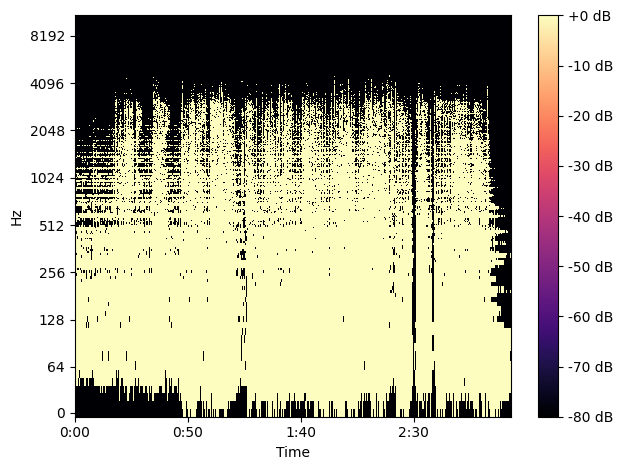

In [ ]:
fig, ax = plt.subplots()

for aud_file in os.listdir(dir):
    if aud_file.endswith('_audio.wav'):

        # Loading File
        file = os.path.join(dir, aud_file)
        aud, sr = librosa.load(file)

        # Bandpass Filter
        aud = bandpass_filter(aud, 50, 3000, sr)

        # Partition Data
        aud = partition(aud, sr)

        # Clusterize Data
        labels, img = clusterize(aud, sr)

        # Segmentation of Clusters
        segment = segmentation(aud, labels, sr)

        # Spectral Subtraction
        back_aud, fore_aud = spectral_subtraction(aud, segment, sr)

        sf.write(file+'_back.wav', back_aud, sr)
        sf.write(file+'_fore.wav', fore_aud, sr)

fig.colorbar(img, ax=ax, format='%+2.0f dB', orientation='vertical')
plt.tight_layout()
plt.show()

In [ ]:
for aud in os.listdir(dir):
    if aud.endswith('_back.wav'):

        print('Background Music')
        display(Audio(os.path.join(dir, aud)))

        print('Foreground Music')
        display(Audio(os.path.join(dir, aud).split('_back.wav')[0]+'_fore.wav'))

Output hidden; open in https://colab.research.google.com to view.